In [1]:
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from typing import Iterable, Optional
from IPython.display import display

# Stats / Forecasting utils
from metrics_pipeline import compute_metrics_with_utilsforecast
from shared_forecast_utils import (
    SPLIT_YEARS,
    FAMILY_MAP,
    get_split_masks,
    make_future_dates,
    historic_avg_last_season,
    run_statsforecast_model,
    run_any_model,
    get_friendly_model_name,
 )

/home/vscode/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    a = pd.concat([y_true.rename('y'), y_pred.rename('yhat')], axis=1).dropna()
    if a.empty:
        return float('nan')
    return float(np.sqrt(np.mean((a['y'] - a['yhat']) ** 2)))


def _compute_fc_single_series(
    pdf: pd.DataFrame,
    value_col: str,
    h: int,
    season_length: int,
    methods: Iterable[str],
    date_col: str = "date",
    freq: str = "MS",
    tune: bool = True,
    ml_param_grids: Optional[dict] = None,
    arima_orders: Optional[list[tuple[int, int, int]]] = None,
    neural_param_grids: Optional[dict] = None,
    verbose: bool = True,
 ):
    """Compute forecasts (val & test) for a single series.

    Leakage control:
    - Tune hyperparameters ONLY on Train->Val.
    - Then refit on Train+Val to forecast Test.
    """
    ds = pd.to_datetime(pdf[date_col])
    y = pdf[value_col].astype(float).to_numpy()

    train_mask, val_mask, test_mask = get_split_masks(ds)
    ds_train, y_train = ds[train_mask], y[train_mask]
    ds_train_val, y_train_val = ds[train_mask | val_mask], y[train_mask | val_mask]

    ds_val_h = make_future_dates(SPLIT_YEARS["val"][0], h, freq=freq)
    ds_test_h = make_future_dates(SPLIT_YEARS["test"][0], h, freq=freq)

    actuals = pd.Series(y, index=ds)
    ytrue_val = actuals.reindex(ds_val_h)
    ytrue_test = actuals.reindex(ds_test_h)

    df_train = pd.DataFrame({"unique_id": "series1", "ds": ds_train, "y": y_train})
    df_train_val = pd.DataFrame({"unique_id": "series1", "ds": ds_train_val, "y": y_train_val})

    # defaults
    arima_orders = arima_orders or [(0, 1, 1), (1, 1, 1), (2, 1, 2)]
    ml_param_grids = ml_param_grids or {
        "ridge": [{"alpha": a} for a in (0.1, 1.0, 10.0)],
        "rf": [
            {"n_estimators": 300, "max_depth": None, "min_samples_leaf": 1},
            {"n_estimators": 500, "max_depth": 10, "min_samples_leaf": 1},
            {"n_estimators": 500, "max_depth": 10, "min_samples_leaf": 3},
        ],
        "gbr": [
            {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 3},
            {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 3},
            {"n_estimators": 300, "learning_rate": 0.1, "max_depth": 3},
        ],
        "linreg": [{}],
    }
    neural_param_grids = neural_param_grids or {
        "rnn": [{"input_size": season_length * 2, "max_steps": 250, "learning_rate": 1e-3}],
        "nbeats": [{"input_size": season_length * 2, "max_steps": 250, "learning_rate": 1e-3}],
        "nhits": [{"input_size": season_length * 2, "max_steps": 250, "learning_rate": 1e-3}],
        "mlp": [{"input_size": season_length * 2, "max_steps": 250, "learning_rate": 1e-3}],
    }

    out = {}
    for method in methods:
        m = method.lower().strip()
        family = FAMILY_MAP.get(m, "custom")
        best = {"params": None, "arima_order": (1, 1, 1), "rmse": float("inf")}

        if verbose:
            print(f"Running {m} (family={family})")

        # --- VAL: tune on train only ---
        if m == "historic_average":
            yhat_val = pd.Series(historic_avg_last_season(y_train, h, season_length), index=ds_val_h)
            best["rmse"] = _rmse(ytrue_val, yhat_val)
        elif family == "statistical" and m == "arima" and tune:
            for order in arima_orders:
                try:
                    pred = run_statsforecast_model(df_train, h=h, method=m, season_length=season_length, arima_order=order, freq=freq)
                    pred = pred.reindex(ds_val_h)
                    score = _rmse(ytrue_val, pred)
                    if score < best["rmse"]:
                        best = {"params": None, "arima_order": order, "rmse": score}
                        yhat_val = pred
                except Exception as e:
                    if verbose:
                        print(f"  ARIMA order {order} failed: {e}")
            if best["rmse"] == float("inf"):
                # fallback
                yhat_val = run_statsforecast_model(df_train, h=h, method=m, season_length=season_length, freq=freq).reindex(ds_val_h)
                best["rmse"] = _rmse(ytrue_val, yhat_val)
        elif family == "ml" and tune:
            grid = ml_param_grids.get(m, [{}])
            for params in grid:
                try:
                    pred = run_any_model(df_train, h=h, method=m, season_length=season_length, freq=freq, params=params)
                    pred = pred.reindex(ds_val_h)
                    score = _rmse(ytrue_val, pred)
                    if score < best["rmse"]:
                        best = {"params": params, "arima_order": (1, 1, 1), "rmse": score}
                        yhat_val = pred
                except Exception as e:
                    if verbose:
                        print(f"  ML params {params} failed: {e}")
            if best["rmse"] == float("inf"):
                yhat_val = run_any_model(df_train, h=h, method=m, season_length=season_length, freq=freq).reindex(ds_val_h)
                best["rmse"] = _rmse(ytrue_val, yhat_val)
        elif family == "neural" and tune:
            grid = neural_param_grids.get(m, [{}])
            for params in grid:
                try:
                    pred = run_any_model(df_train, h=h, method=m, season_length=season_length, freq=freq, params=params)
                    pred = pred.reindex(ds_val_h)
                    score = _rmse(ytrue_val, pred)
                    if score < best["rmse"]:
                        best = {"params": params, "arima_order": (1, 1, 1), "rmse": score}
                        yhat_val = pred
                except Exception as e:
                    if verbose:
                        print(f"  Neural params {params} failed: {e}")
            if best["rmse"] == float("inf"):
                yhat_val = run_any_model(df_train, h=h, method=m, season_length=season_length, freq=freq).reindex(ds_val_h)
                best["rmse"] = _rmse(ytrue_val, yhat_val)
        else:
            yhat_val = run_any_model(df_train, h=h, method=m, season_length=season_length, freq=freq).reindex(ds_val_h)
            best["rmse"] = _rmse(ytrue_val, yhat_val)

        # --- TEST: refit on train+val using best params/order ---
        if m == "historic_average":
            yhat_test = pd.Series(historic_avg_last_season(y_train_val, h, season_length), index=ds_test_h)
        elif family == "statistical" and m == "arima":
            yhat_test = run_statsforecast_model(
                df_train_val, h=h, method=m, season_length=season_length, arima_order=best["arima_order"], freq=freq
            ).reindex(ds_test_h)
        else:
            yhat_test = run_any_model(
                df_train_val, h=h, method=m, season_length=season_length, freq=freq, params=best["params"]
            ).reindex(ds_test_h)

        out[m] = {
            "val": yhat_val,
            "test": yhat_test,
            "val_true": ytrue_val,
            "test_true": ytrue_test,
            "best_params": best["params"],
            "best_arima_order": best["arima_order"],
            "val_rmse": best["rmse"],
        }
    return out

In [3]:
def basic_forecast_single_series(
    df: pl.DataFrame,
    value_col: str = "import_value_eur",
    date_col: str = "date",
    forecast_methods: Optional[Iterable[str]] = None,
    h: int = 12,
    h_future: int = 12,
    season_length: int = 12,
    export_csv: bool = False,
    freq: str = "MS",
    tune: bool = True,
    results_csv_path: str = "../results/forecast_results_all_models.csv",
    plot_future: bool = False,
 ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Run all models and return (metrics_df, forecasts_df).

    Leakage control:
    - Hyperparameters are selected using Train→Val only.
    - Test predictions are produced by refitting on Train+Val.

    Outputs:
    - `metrics_df`: per-model metrics for Val/Test.
    - `forecasts_df`: tidy predictions for Val/Test/Future.
    """
    if forecast_methods is None:
        forecast_methods = tuple(FAMILY_MAP.keys())

    # Convert to pandas
    pdf = df.select([date_col, value_col]).to_pandas()
    pdf[date_col] = pd.to_datetime(pdf[date_col])
    pdf = pdf.sort_values(date_col)

    # Compute val/test forecasts (with leakage-safe tuning)
    fc = _compute_fc_single_series(
        pdf,
        value_col=value_col,
        h=h,
        season_length=season_length,
        methods=forecast_methods,
        date_col=date_col,
        freq=freq,
        tune=tune,
        verbose=True,
    )

    # Build metrics table + forecasts table
    metric_rows = []
    fc_rows = []
    for m, res in fc.items():
        val_true = res["val_true"]
        test_true = res["test_true"]

        # actuals
        val_df = pd.DataFrame({"unique_id": "series1", "ds": val_true.index, "y": val_true.values})
        test_df = pd.DataFrame({"unique_id": "series1", "ds": test_true.index, "y": test_true.values})

        # predictions: always 'yhat'
        val_pred_df = pd.DataFrame({"unique_id": "series1", "ds": res["val"].index, "yhat": res["val"].values})
        test_pred_df = pd.DataFrame({"unique_id": "series1", "ds": res["test"].index, "yhat": res["test"].values})

        # compute metrics
        val_metrics = compute_metrics_with_utilsforecast(val_df, val_pred_df, model_col="yhat")
        test_metrics = compute_metrics_with_utilsforecast(test_df, test_pred_df, model_col="yhat")

        metric_rows.append({
            "Model": m,
            "Family": FAMILY_MAP.get(m, "custom"),
            "Split": "Val",
            "MAE": val_metrics["MAE"].values[0],
            "RMSE": val_metrics["RMSE"].values[0],
            "MAPE": val_metrics["MAPE"].values[0],
            "R2": val_metrics["R2"].values[0],
            "OPE": val_metrics["OPE"].values[0],
            "val_rmse_for_tuning": res.get("val_rmse"),
            "best_params": res.get("best_params"),
            "best_arima_order": res.get("best_arima_order"),
        })
        metric_rows.append({
            "Model": m,
            "Family": FAMILY_MAP.get(m, "custom"),
            "Split": "Test",
            "MAE": test_metrics["MAE"].values[0],
            "RMSE": test_metrics["RMSE"].values[0],
            "MAPE": test_metrics["MAPE"].values[0],
            "R2": test_metrics["R2"].values[0],
            "OPE": test_metrics["OPE"].values[0],
            "val_rmse_for_tuning": res.get("val_rmse"),
            "best_params": res.get("best_params"),
            "best_arima_order": res.get("best_arima_order"),
        })

        # store val/test forecasts (tidy)
        for split_name in ("val", "test"):
            pred = res[split_name]
            true = res[f"{split_name}_true"]
            a = pd.DataFrame({"ds": pred.index, "yhat": pred.values}).merge(
                pd.DataFrame({"ds": true.index, "y": true.values}),
                on="ds",
                how="left",
            )
            a["split"] = split_name
            a["model"] = m
            a["family"] = FAMILY_MAP.get(m, "custom")
            fc_rows.append(a)

    metrics_df = pd.DataFrame(metric_rows)
    forecasts_df = pd.concat(fc_rows, ignore_index=True) if fc_rows else pd.DataFrame()

    # --- Future forecast: refit on FULL history (not using future actuals) ---
    ds_full = pd.to_datetime(pdf[date_col])
    y_full = pdf[value_col].astype(float).to_numpy()
    df_full = pd.DataFrame({"unique_id": "series1", "ds": ds_full, "y": y_full})
    last_date = ds_full.max()
    future_dates = make_future_dates(last_date + pd.offsets.MonthBegin(1), h_future, freq=freq)

    future_rows = []
    for method in forecast_methods:
        m = method.lower().strip()
        family = FAMILY_MAP.get(m, "custom")

        if m == "historic_average":
            yhat_future = pd.Series(historic_avg_last_season(y_full, h_future, season_length), index=future_dates)
        else:
            tuned = fc.get(m, {}).get("best_params")
            arima_order = fc.get(m, {}).get("best_arima_order", (1, 1, 1))
            yhat_future = run_any_model(
                df_full,
                h=h_future,
                method=m,
                season_length=season_length,
                freq=freq,
                arima_order=arima_order,
                params=tuned,
            )
            yhat_future = yhat_future.reindex(future_dates)
        future_rows.append(pd.DataFrame({
            "ds": yhat_future.index,
            "yhat": yhat_future.values,
            "y": np.nan,
            "split": "future",
            "model": m,
            "family": family,
        }))

    future_df = pd.concat(future_rows, ignore_index=True) if future_rows else pd.DataFrame()
    forecasts_df = pd.concat([forecasts_df, future_df], ignore_index=True) if not forecasts_df.empty else future_df

    if export_csv:
        os.makedirs(os.path.dirname(results_csv_path), exist_ok=True)
        forecasts_df.to_csv(results_csv_path, index=False)
        print(f"Saved combined forecasts to: {results_csv_path}")

    if plot_future:
        # basic quicklook plot (kept optional; preferred visuals are in dedicated cells below)
        plt.figure(figsize=(12, 5))
        pdf_plot = pdf[pdf[date_col] >= "2020-01-01"]
        plt.plot(pdf_plot[date_col], pdf_plot[value_col], color="black", lw=1.6, label="Actual")
        for m in list(forecast_methods)[:8]:
            g = forecasts_df[(forecasts_df["split"] == "future") & (forecasts_df["model"] == m)]
            if not g.empty:
                plt.plot(g["ds"], g["yhat"], linestyle="-.", label=f"{m} (Future)")
        plt.xlabel("Date")
        plt.ylabel(value_col)
        plt.title(f"Future forecasts for {value_col}")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.show()

    return metrics_df, forecasts_df

In [4]:
def show_results(results_df: pd.DataFrame) -> pd.DataFrame:
    disp = results_df.copy()
    for c in ["MAE","RMSE","MAPE","R2"]:
        disp[c] = disp[c].astype(float).round(3)
    display(disp)
    return disp


In [5]:
# Load CSV
df = pl.read_csv("../data/Kaffee_Tee_Mate_und_Gewuerze_2007-2025_cleaned.csv", separator=",")
df.head(5)


import_value_eur,export_value_eur,import_qty_kg,export_qty_kg,date,export_value_eur_real_2025,import_value_eur_real_2025
i64,i64,i64,i64,str,f64,f64
27832809,16896986,9857615,4582769,"""2007-01-01""",2.7407e7,4.5145e7
24173222,13690849,9148603,3889454,"""2007-02-01""",2.2207e7,3.9209e7
27640476,19932106,10072434,5472440,"""2007-03-01""",3.2330e7,4.4833e7
25348582,16598993,9156889,4383299,"""2007-04-01""",2.6924e7,4.1115e7
28266053,16412072,10886785,4189638,"""2007-05-01""",2.6620e7,4.5848e7


In [6]:
# Configure target + output files (so copies don't overwrite each other)
TARGET_COL = "import_qty_kg"  # changed for this notebook
RESULTS_ALL_CSV = f"../results/forecast_results_{TARGET_COL}_all_models.csv"
RESULTS_FUTURE_CSV = f"../results/forecast_results_{TARGET_COL}_future_only.csv"

metrics_df, forecasts_df = basic_forecast_single_series(
    df,
    value_col=TARGET_COL,
    date_col="date",
    forecast_methods=tuple(FAMILY_MAP.keys()),
    h=12,
    h_future=12,
    season_length=12,
    export_csv=True,
    results_csv_path=RESULTS_ALL_CSV,
    tune=True,
    plot_future=False,
 )

Running naive (family=baseline)
Running seasonal_naive (family=baseline)
Running historic_average (family=baseline)
Running rw_drift (family=statistical)
Running arima (family=statistical)
Running auto_arima (family=statistical)
Running linreg (family=ml)
Running ridge (family=ml)
Running rf (family=ml)
Running gbr (family=ml)
Running rnn (family=neural)


2025-12-30 19:43:21,687	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-30 19:43:21,865	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | hist_encoder | RNN           | 49.8 K | train | 0    
4 | mlp_decoder  | MLP           | 16.6 K | train | 0    
---------------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Tot

Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, v_num=48, train_loss_step=0.00962, train_loss_epoch=0.00962]

`Trainer.fit` stopped: `max_steps=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, v_num=48, train_loss_step=0.00962, train_loss_epoch=0.00962]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.62it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | hist_encoder | RNN           | 49.8 K | train | 0    
4 | mlp_decoder  | MLP           | 16.6 K | train | 0    
---------------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
0         Total Flops



Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 33.78it/s, v_num=50, train_loss_step=0.0058, train_loss_epoch=0.0058]  

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s, v_num=50, train_loss_step=0.0058, train_loss_epoch=0.0058]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.42it/s]
Running nbeats (family=neural)


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 2.4 M  | train | 0    
---------------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s, v_num=52, train_loss_step=2.34e-11, train_loss_epoch=2.34e-11]

`Trainer.fit` stopped: `max_steps=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, v_num=52, train_loss_step=2.34e-11, train_loss_epoch=2.34e-11]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.20it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 2.4 M  | train | 0    
---------------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
0         Total Flops



Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s, v_num=54, train_loss_step=2.25e-13, train_loss_epoch=2.25e-13]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s, v_num=54, train_loss_step=2.25e-13, train_loss_epoch=2.25e-13]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.70it/s]

Seed set to 1



Running nhits (family=neural)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 2.4 M  | train | 0    
---------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s, v_num=56, train_loss_step=1.92e-8, train_loss_epoch=1.92e-8]  

`Trainer.fit` stopped: `max_steps=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s, v_num=56, train_loss_step=1.92e-8, train_loss_epoch=1.92e-8]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.99it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 2.4 M  | train | 0    
---------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s, v_num=58, train_loss_step=2.11e-11, train_loss_epoch=2.11e-11]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, v_num=58, train_loss_step=2.11e-11, train_loss_epoch=2.11e-11]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.56it/s]

Seed set to 1



Running mlp (family=neural)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | mlp          | ModuleList    | 1.1 M  | train | 0    
4 | out          | Linear        | 12.3 K | train | 0    
---------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.350     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s, v_num=60, train_loss_step=2.48e-7, train_loss_epoch=2.48e-7]  

`Trainer.fit` stopped: `max_steps=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 26.81it/s, v_num=60, train_loss_step=2.48e-7, train_loss_epoch=2.48e-7]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.46it/s]

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | mlp          | ModuleList    | 1.1 M  | train | 0    
4 | out          | Linear        | 12.3 K | train | 0    
---------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.350     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s, v_num=62, train_loss_step=7.7e-5, train_loss_epoch=7.7e-5]    

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s, v_num=62, train_loss_step=7.7e-5, train_loss_epoch=7.7e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | hist_encoder | RNN           | 49.8 K | train | 0    
4 | mlp_decoder  | MLP           | 16.6 K | train | 0    
---------------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 32.52it/s, v_num=64, train_loss_step=0.0232, train_loss_epoch=0.0232]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s, v_num=64, train_loss_step=0.0232, train_loss_epoch=0.0232]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 2.4 M  | train | 0    
---------------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s, v_num=66, train_loss_step=1.19e-12, train_loss_epoch=1.19e-12]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.85it/s, v_num=66, train_loss_step=1.19e-12, train_loss_epoch=1.19e-12]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.39it/s]

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 2.4 M  | train | 0    
---------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s, v_num=68, train_loss_step=1.12e-8, train_loss_epoch=1.12e-8]  

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s, v_num=68, train_loss_step=1.12e-8, train_loss_epoch=1.12e-8]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MSE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | mlp          | ModuleList    | 1.1 M  | train | 0    
4 | out          | Linear        | 12.3 K | train | 0    
---------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.350     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
0         Total Flops



Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s, v_num=70, train_loss_step=0.000124, train_loss_epoch=0.000124]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s, v_num=70, train_loss_step=0.000124, train_loss_epoch=0.000124]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.06it/s]
Saved combined forecasts to: ../results/forecast_results_import_qty_kg_all_models.csv


In [7]:
show_results(metrics_df)

,Model,Family,Split,MAE,RMSE,MAPE,R2,OPE,val_rmse_for_tuning,best_params,best_arima_order
0,naive,baseline,Val,745263.417,933814.217,0.110,-1.405,9.859209,9.338142e+05,None,"(1, 1, 1)"
1,naive,baseline,Test,415205.417,567581.644,0.058,-0.006,0.604029,9.338142e+05,None,"(1, 1, 1)"
2,seasonal_naive,baseline,Val,645523.750,715625.057,0.089,-0.413,-0.984702,7.156251e+05,None,"(1, 1, 1)"
3,seasonal_naive,baseline,Test,678970.833,726277.323,0.091,-0.648,-3.560114,7.156251e+05,None,"(1, 1, 1)"
4,historic_average,baseline,Val,537045.111,606292.706,0.075,-0.014,-0.984702,6.062927e+05,None,"(1, 1, 1)"
5,historic_average,baseline,Test,504990.542,624881.054,0.067,-0.220,-3.560114,6.062927e+05,None,"(1, 1, 1)"
6,rw_drift,statistical,Val,609696.229,807410.853,0.091,-0.798,7.885481,8.074109e+05,None,"(1, 1, 1)"
7,rw_drift,statistical,Test,431736.140,571813.467,0.059,-0.021,-1.282282,8.074109e+05,None,"(1, 1, 1)"
8,arima,statistical,Val,517761.887,630055.507,0.075,-0.095,2.755444,6.300555e+05,None,"(2, 1, 2)"
9,arima,statistical,Test,522964.679,636459.759,0.069,-0.265,-4.092433,6.300555e+05,None,"(2, 1, 2)"


,Model,Family,Split,MAE,RMSE,MAPE,R2,OPE,val_rmse_for_tuning,best_params,best_arima_order
0,naive,baseline,Val,745263.417,933814.217,0.110,-1.405,9.859209,9.338142e+05,None,"(1, 1, 1)"
1,naive,baseline,Test,415205.417,567581.644,0.058,-0.006,0.604029,9.338142e+05,None,"(1, 1, 1)"
2,seasonal_naive,baseline,Val,645523.750,715625.057,0.089,-0.413,-0.984702,7.156251e+05,None,"(1, 1, 1)"
3,seasonal_naive,baseline,Test,678970.833,726277.323,0.091,-0.648,-3.560114,7.156251e+05,None,"(1, 1, 1)"
4,historic_average,baseline,Val,537045.111,606292.706,0.075,-0.014,-0.984702,6.062927e+05,None,"(1, 1, 1)"
5,historic_average,baseline,Test,504990.542,624881.054,0.067,-0.220,-3.560114,6.062927e+05,None,"(1, 1, 1)"
6,rw_drift,statistical,Val,609696.229,807410.853,0.091,-0.798,7.885481,8.074109e+05,None,"(1, 1, 1)"
7,rw_drift,statistical,Test,431736.140,571813.467,0.059,-0.021,-1.282282,8.074109e+05,None,"(1, 1, 1)"
8,arima,statistical,Val,517761.887,630055.507,0.075,-0.095,2.755444,6.300555e+05,None,"(2, 1, 2)"
9,arima,statistical,Test,522964.679,636459.759,0.069,-0.265,-4.092433,6.300555e+05,None,"(2, 1, 2)"


In [8]:
pdf_actual = df.select(["date", TARGET_COL]).to_pandas()
pdf_actual["date"] = pd.to_datetime(pdf_actual["date"])
pdf_actual = pdf_actual.sort_values("date")

last_obs_date = pdf_actual["date"].max()
pdf_plot = pdf_actual[pdf_actual["date"] >= "2020-01-01"]
print(f"Last observed date: {last_obs_date.date()} | target={TARGET_COL}")

Last observed date: 2025-09-01 | target=import_qty_kg


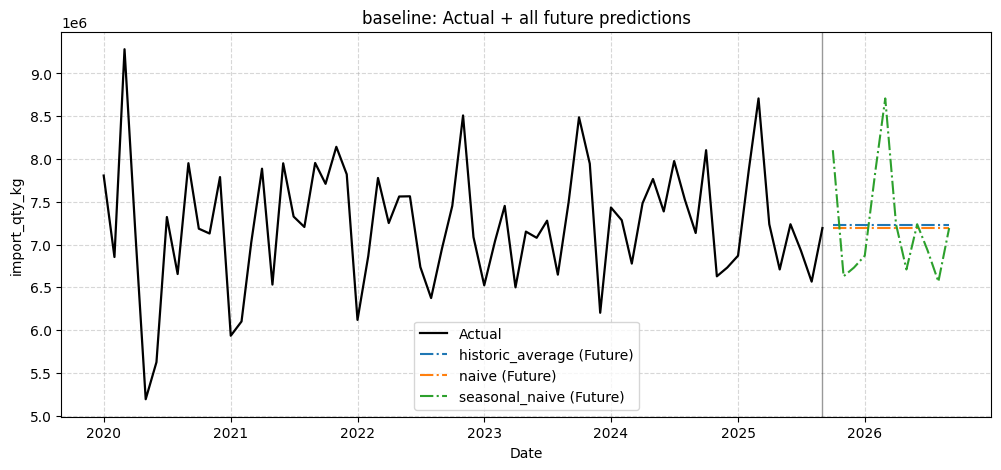

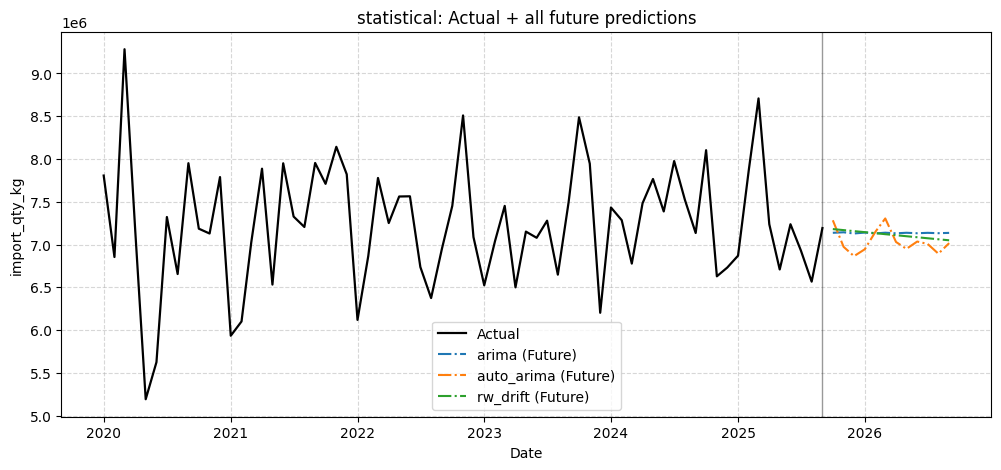

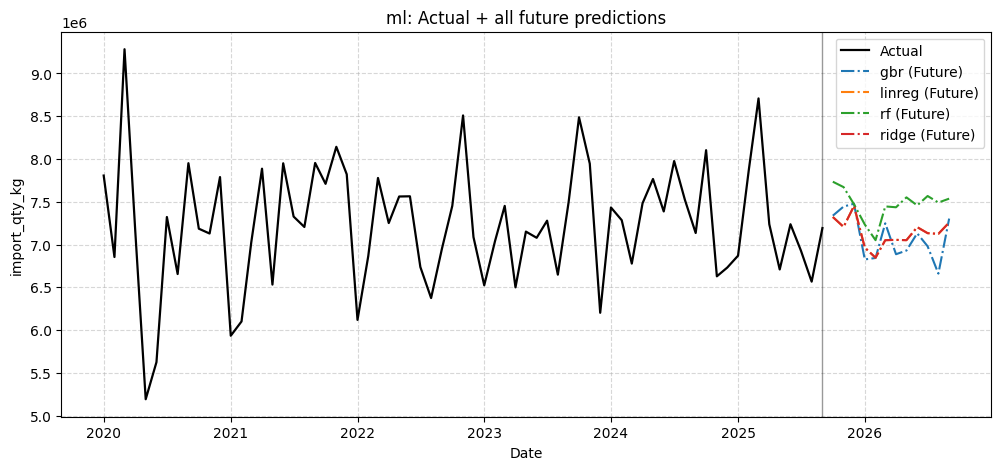

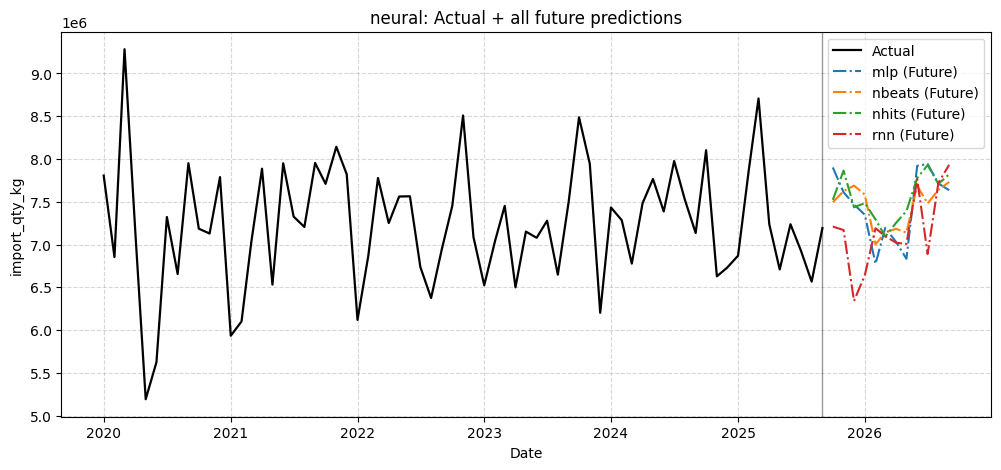

In [9]:
def plot_future_by_family(
    forecasts_df: pd.DataFrame,
    pdf_plot: pd.DataFrame,
    *,
    value_col: str,
    date_col: str = "date",
    families=("baseline", "statistical", "ml", "neural"),
 ):
    """One time series + all FUTURE predictions per family."""
    for fam in families:
        g = forecasts_df[(forecasts_df["split"] == "future") & (forecasts_df["family"] == fam)].copy()
        if g.empty:
            print(f"No future forecasts for family: {fam}")
            continue
        plt.figure(figsize=(12, 5))
        plt.plot(pdf_plot[date_col], pdf_plot[value_col], color="black", lw=1.6, label="Actual")
        for model in sorted(g["model"].unique()):
            mdf = g[g["model"] == model].sort_values("ds")
            plt.plot(mdf["ds"], mdf["yhat"], linestyle="-.", label=f"{model} (Future)")
        plt.axvline(pdf_plot[date_col].max(), color="black", lw=1, alpha=0.4)
        plt.title(f"{fam}: Actual + all future predictions")
        plt.xlabel("Date")
        plt.ylabel(value_col)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.show()

plot_future_by_family(forecasts_df, pdf_plot, value_col=TARGET_COL)

Best 3 models by Test RMSE: ['naive', 'rw_drift', 'historic_average']


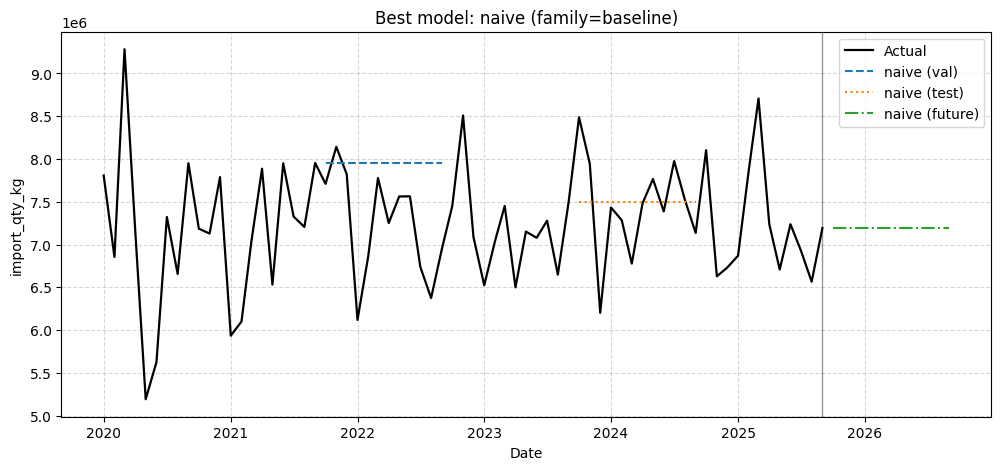

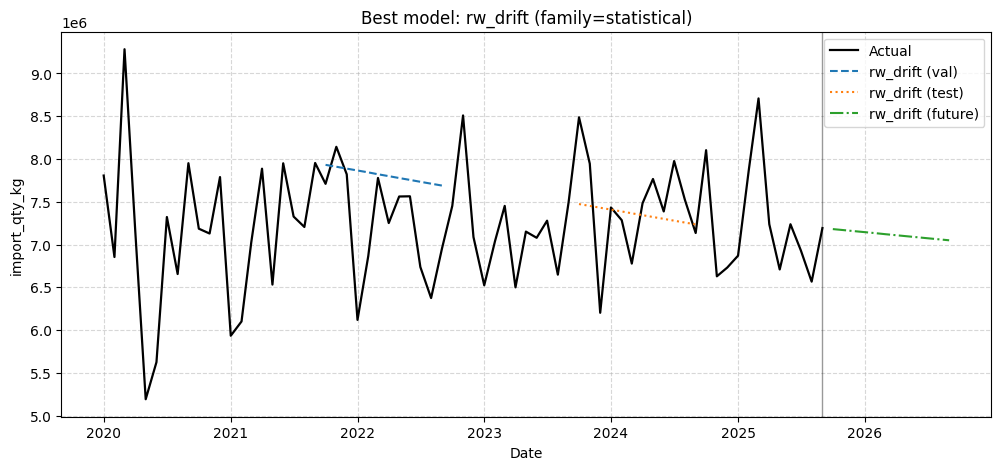

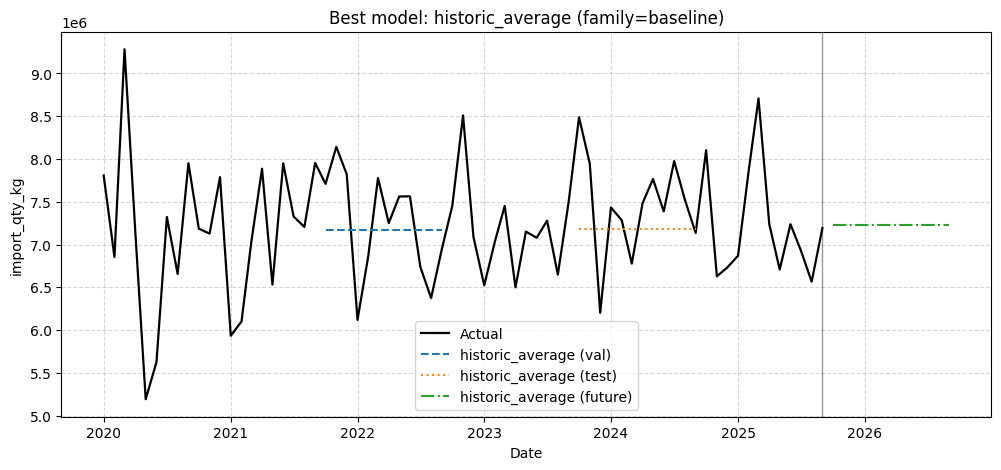

In [10]:
# Pick best 3 models by Test RMSE and visualize each separately
tmp = metrics_df.copy()
tmp = tmp[tmp["Split"] == "Test"].copy()
tmp["RMSE"] = pd.to_numeric(tmp["RMSE"], errors="coerce")
best3 = tmp.sort_values("RMSE").head(3)["Model"].tolist()
print("Best 3 models by Test RMSE:", best3)

def plot_model_all_splits(
    forecasts_df: pd.DataFrame,
    pdf_plot: pd.DataFrame,
    model: str,
    *,
    value_col: str,
    date_col: str = "date",
 ):
    g = forecasts_df[forecasts_df["model"] == model].copy()
    if g.empty:
        print(f"No forecasts found for model: {model}")
        return
    plt.figure(figsize=(12, 5))
    plt.plot(pdf_plot[date_col], pdf_plot[value_col], color="black", lw=1.6, label="Actual")
    for split, style in [("val", "--"), ("test", ":"), ("future", "-.")]:
        sg = g[g["split"] == split].sort_values("ds")
        if not sg.empty:
            plt.plot(sg["ds"], sg["yhat"], linestyle=style, label=f"{model} ({split})")
    plt.axvline(pdf_plot[date_col].max(), color="black", lw=1, alpha=0.4)
    fam = g["family"].dropna().unique()
    fam_str = fam[0] if len(fam) else "unknown"
    plt.title(f"Best model: {model} (family={fam_str})")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

for m in best3:
    plot_model_all_splits(forecasts_df, pdf_plot, m, value_col=TARGET_COL)

In [11]:
# Save FUTURE-only predictions to a separate CSV (self-contained + non-overwriting)
import os
import pandas as pd

future_csv_path = globals().get("RESULTS_FUTURE_CSV", "../results/forecast_results_future_only.csv")
all_models_csv_path = globals().get("RESULTS_ALL_CSV", "../results/forecast_results_all_models.csv")

if "forecasts_df" in globals() and isinstance(forecasts_df, pd.DataFrame) and not forecasts_df.empty:
    _src_forecasts_df = forecasts_df.copy()
else:
    _src_forecasts_df = pd.read_csv(all_models_csv_path)

future_only_df = _src_forecasts_df[_src_forecasts_df["split"].astype(str).str.lower().eq("future")].copy()
future_only_df["ds"] = pd.to_datetime(future_only_df["ds"], errors="coerce")
future_only_df = future_only_df.sort_values(["model", "ds"], kind="stable")

os.makedirs(os.path.dirname(future_csv_path), exist_ok=True)
future_only_df.to_csv(future_csv_path, index=False)
print(f"Saved future-only forecasts to: {future_csv_path} ({len(future_only_df)} rows)")

Saved future-only forecasts to: ../results/forecast_results_import_qty_kg_future_only.csv (168 rows)
